In [1]:
import torch
import torch.nn as nn
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torchsummary import summary

from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# TODO: define train set and test set
train_set = datasets.MNIST(
    root="../data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_set = datasets.MNIST(
    root="../data",
    train=False,
    transform=ToTensor()
)



100%|██████████| 9912422/9912422 [00:00<00:00, 212939052.81it/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 108060387.00it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 159716666.97it/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19360293.46it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



In [3]:
# TODO: define dataloader for train and test
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

In [9]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        # TODO: define layers of your model
        # input 28*28*1
        self.layer1_conv = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5) # 24*24*10
        self.layer2_max_pooling = nn.MaxPool2d(kernel_size=2, stride=2) # 12*12*10
        self.layer3_conv = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5) # 8*8*20
        self.layer4_max_pooling = nn.MaxPool2d(kernel_size=2, stride=2) # 4*4*20
        self.layer5_fully_connected = nn.Linear(in_features=4*4*20, out_features=10)
        self.relu = nn.ReLU()
    def forward(self, x):
        # TODO: define forward for your model
        x = self.layer1_conv(x)
        x = self.layer2_max_pooling(x)
        x = self.layer3_conv(x)
        x = self.layer4_max_pooling(x)
        x = torch.flatten(x, 1)
        x = self.layer5_fully_connected(x)
        output = self.relu(x)
        return output

In [10]:
# Do not change this cell
def caluculate_acc(data, model, length):
  model.eval()
  acc = 0
  for images, label in data:
    with torch.no_grad():
      images = images.to(device)
      label = label.to(device)
      yp = model(images)
      yp = torch.nn.functional.softmax(yp, dim=1)
      yp = torch.argmax(yp, 1)
      acc += torch.sum(yp == label)
  return acc / length

In [11]:
# Do not change this cell
def train_one_epoch(model, data, optimizer, criterion, length):
  model.train()
  acc = 0
  for images, labels in data:
    imgs = torch.autograd.Variable(images).to(device)
    label = torch.autograd.Variable(labels).to(device)
    optimizer.zero_grad()
    yp = model(imgs)
    loss = criterion(yp, label)
    loss.backward()
    optimizer.step()
    yp = torch.argmax(yp, 1)
    acc += torch.sum(yp == label)
  return loss.item(), acc / length

In [12]:
# TODO: define your model dont forget about device :)
model = Model().to(device)

# TODO: define optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.03)

# TODO: define loss
criterion = torch.nn.CrossEntropyLoss()

# model summary
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 24, 24]             260
         MaxPool2d-2           [-1, 10, 12, 12]               0
            Conv2d-3             [-1, 20, 8, 8]           5,020
         MaxPool2d-4             [-1, 20, 4, 4]               0
            Linear-5                   [-1, 10]           3,210
              ReLU-6                   [-1, 10]               0
Total params: 8,490
Trainable params: 8,490
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.07
Params size (MB): 0.03
Estimated Total Size (MB): 0.10
----------------------------------------------------------------


In [13]:
# training process
val_accs = []
accs = []
best_acc = 0
for e in tqdm(range(20)):
  accs.append(train_one_epoch(model, train_loader, optimizer, criterion, len(train_set))[1].item())
  val_accs.append(caluculate_acc(test_loader, model, len(test_set)).item())
  if best_acc < val_accs[-1]:
    torch.save(model, "model.h5")
    best_Acc = val_accs[-1]

  # just a way to avoid pverfitting
  if val_accs[-1] > 0.99 and accs[-1] > 0.99:
    break

  0%|          | 0/20 [00:00<?, ?it/s]

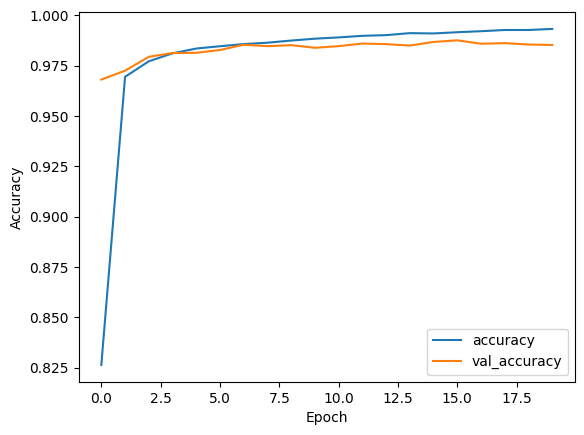

In [14]:
plt.plot(accs, label='accuracy')
plt.plot(val_accs, label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show();

In [15]:
caluculate_acc(test_loader, model, len(test_set)).item(), caluculate_acc(train_loader, model, len(train_set)).item()

(0.9853000044822693, 0.9923166632652283)